# Project Block 2: Advanced Statistics
## Part 2 - Forecasting Queretaro industrial activity
Fabián González Vera A01367585

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statistics as st
from datetime import datetime


## ARIMA(p,d,q)SARIMA(P,D,Q,#p)
---

Read data from CSV file, transform 'Periodos' column to date, in order to make it easier to plot the date againt the % growth of the Industrial Activity in Queretaro.

C:\Users\fabig\AppData\Local\Temp\ipykernel_24436\974229289.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  IAQ['Periodos'] = pd.to_datetime(IAQ['Periodos'])


<Axes: xlabel='Periodos'>

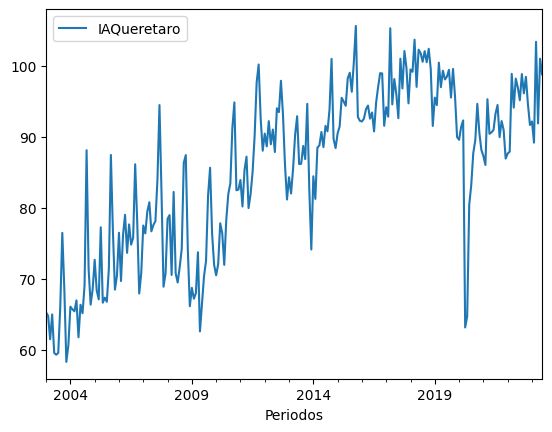

In [2]:
IAQ = pd.read_csv('Indicadores20231012110325.csv')
IAQ['Periodos'] = pd.to_datetime(IAQ['Periodos'])
IAQ=IAQ.set_index(['Periodos'])
IAQ.plot()

In [3]:
IAQ

,IAQueretaro
Periodos,
2003-01-01,65.234491
2003-02-01,64.750420
2003-03-01,61.444991
2003-04-01,64.953065
2003-05-01,59.522348
...,...
2023-02-01,89.168194
2023-03-01,103.384331
2023-04-01,91.876916


(NULL) H0: |φ_1| = 1  => Time series is not stationary <br>
(ALT)  H1: |φ| < 1   => Time series is stationary

In [4]:
from statsmodels.tsa.stattools import adfuller
print(adfuller(IAQ['IAQueretaro'])[1])
#pvalue 

0.3552197579633277


The pvalue returned by the Dickey-Fuller test is 0.3552197579633277 and is greater than 0.05, this suggest that the series is not stationary.

Obtain the logarithm from the column 'IAQueretaro' in order to start the process to convert the Time Series (TS) into a stationary one,then obtain 12th difference since we are analysing the data from a yearly perspective. Now the TS is stationary.

In [5]:
IAQ['lIndAct'] = np.log(IAQ['IAQueretaro'])
# log - log shift 12
IAQ['diff12'] = IAQ['lIndAct'] - IAQ['lIndAct'].shift(12)
IAQ

,IAQueretaro,lIndAct,diff12
Periodos,,,
2003-01-01,65.234491,4.177988,NaN
2003-02-01,64.750420,4.170540,NaN
2003-03-01,61.444991,4.118142,NaN
2003-04-01,64.953065,4.173665,NaN
2003-05-01,59.522348,4.086352,NaN
...,...,...,...
2023-02-01,89.168194,4.490524,0.014323
2023-03-01,103.384331,4.638453,0.044631
2023-04-01,91.876916,4.520450,-0.023967


<Axes: xlabel='Periodos'>

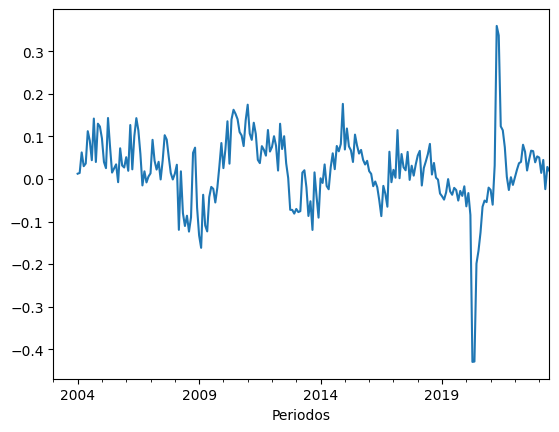

In [6]:
IAQ['diff12'].plot()

In [7]:
adfuller(IAQ['diff12'].dropna())[1]

0.01098300845261186

The pvalue returned by the Dickey-Fuller test for the 12th difference is 0.01098300845261186 and is smaller than 0.05. This means that the Time Series is stationary.

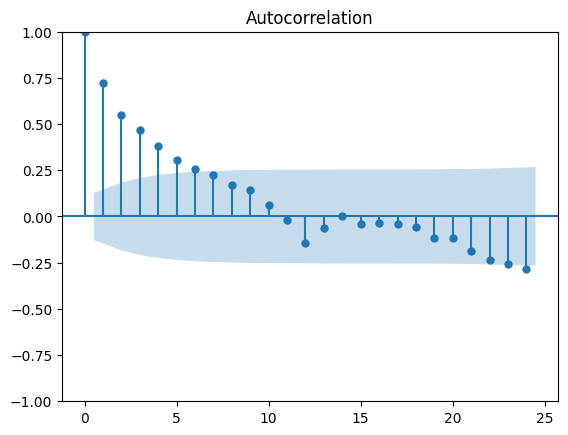

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(IAQ['diff12'].dropna())
plt.show()

The ACF plot initially shows a slow decline, this means it needs a higher order of differencing.

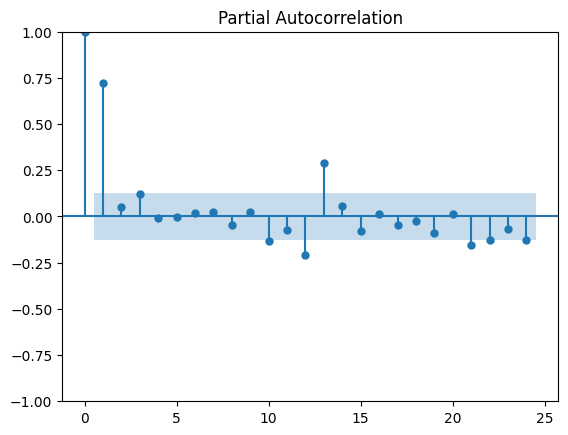

In [9]:
plot_pacf(IAQ['diff12'].dropna())
plt.show()

The PACF shows a sharp decline this means that it may be ideal to add an AR term to the model.

order = (p,d,q), seasonal_order= (P,D,Q,s)<br>
p = 1, because the first LAGs in the PACF display a sharp cutoff.<br>
d = 0, because we are not using the first difference.<br>
q = 0, because the LAGs of the ACF dont display a sharp cutoff or LAG-1 is negative.<br>
P = 0, because we need to check the residuals of a first model to determine the value.<br>
D = 1, because we are using the seasonal difference, in this case the 12th diff.<br>
Q = 0, because we need to check the residuals of a first model to determine the value.<br>
s = 12, because there are 12 observations per year.<br>

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = IAQ['lIndAct']
Aorder = (1, 0, 0)
SAorder = (0, 1, 0, 12)
model = SARIMAX(y, order=Aorder, seasonal_order=SAorder, trend='c', dates=y.index)
model=model.fit()
model.summary()

d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            lIndAct   No. Observations:                  246
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 331.391
Date:                            Fri, 17 Nov 2023   AIC                           -656.782
Time:                                    23:47:40   BIC                           -646.416
Sample:                                01-01-2003   HQIC                          -652.602
                                     - 06-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0059      0.004      1.524      0.127      -0.002       0.013
ar.L1          0.7202      0.034     21.249      0.000       0.654       0.787
sigma2         0.0034      0.000     25.504      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               980.99
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.28
Prob(H) (two-sided):                  0.09   Kurtosis:                        13.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The autoregressive term is positive and is not statistically significant as it´s p-value is above 0.05. <br>This means that annual percent growth of the industrial activity in Queretaro is positive meagerly related to the annual percent growth of the industrial activity of 12 months ago.
The equation would be:<br>

s12.lnIAQ = 0.0059 + 0.7202	∗ar.L1.s12.lnIAQ + error<br>


Further refinements of the model are needed.

In [11]:
model.resid.head(20)

Periodos
2003-01-01    4.157034
2003-02-01    4.149586
2003-03-01    4.097188
2003-04-01    4.152711
2003-05-01    4.065398
2003-06-01    4.061200
2003-07-01    4.065378
2003-08-01    4.169367
2003-09-01    4.315657
2003-10-01    4.206869
2003-11-01    4.043884
2003-12-01    4.083248
2004-01-01   -0.008596
2004-02-01   -0.000686
2004-03-01    0.046296
2004-04-01   -0.020733
2004-05-01    0.008837
2004-06-01    0.080177
2004-07-01    0.003233
2004-08-01   -0.026562
dtype: float64

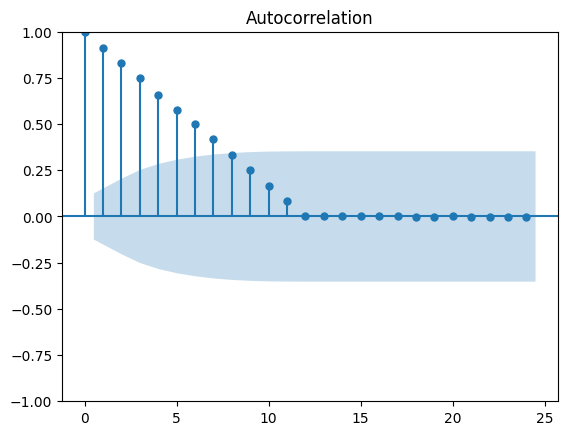

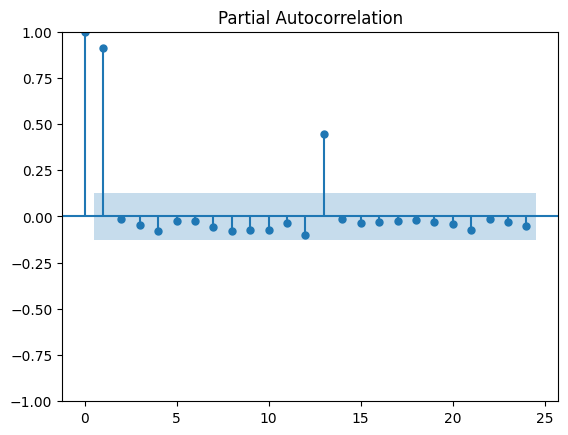

In [12]:
plot_acf(model.resid)
plot_pacf(model.resid)
plt.show()

In the ACF we can see a gradual descent and in the PACF we see a sharp drop after the first lag, but in actuality this is because we are working with the 12th difference, meaning that there are such big residuals due to the fact that it does not take into account the first 12 months.<br>

This can be further appreciated in the following plot where it takes all the values but the first 12.
In those plots all values but the 12th and 24th are not that significant, this is also reinforced when plotting the predictions made by the model in comparison to logarith of 'lIndAct'.

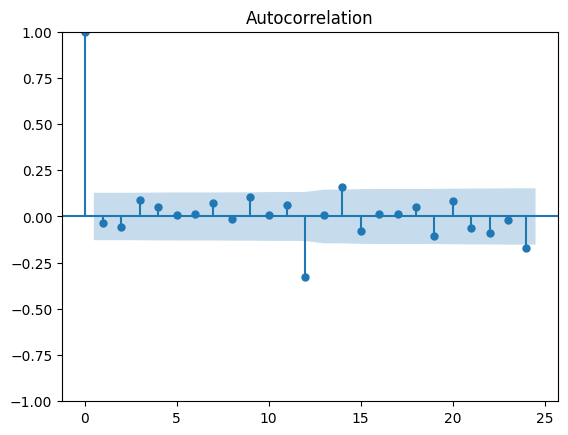

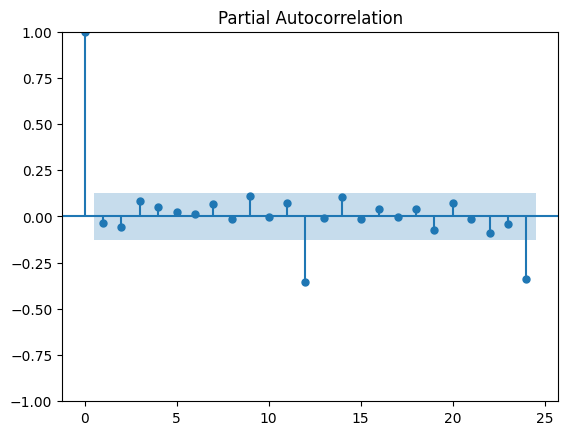

In [13]:
plot_acf(model.resid[12:])
plot_pacf(model.resid[12:])
plt.show()

We can see that the prediction for the first 12 months are 0, but on the 13th month they become similar to the ones of the real series.

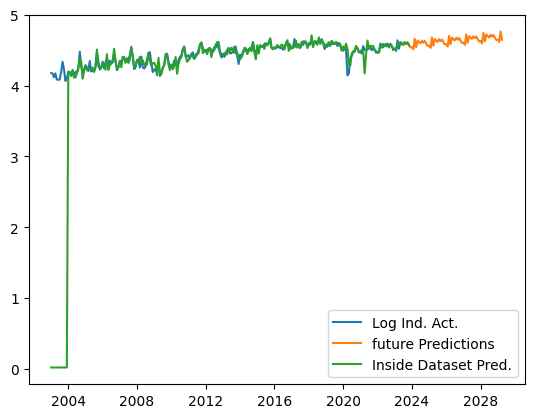

In [14]:
#IAQ['lIndAct'].plot()
plt.plot(IAQ['lIndAct'], label='Log Ind. Act.')
plt.plot(model.forecast(70),label='future Predictions')
plt.plot(model.predict(start = 0, end = 250), label = 'Inside Dataset Pred.')
plt.legend()

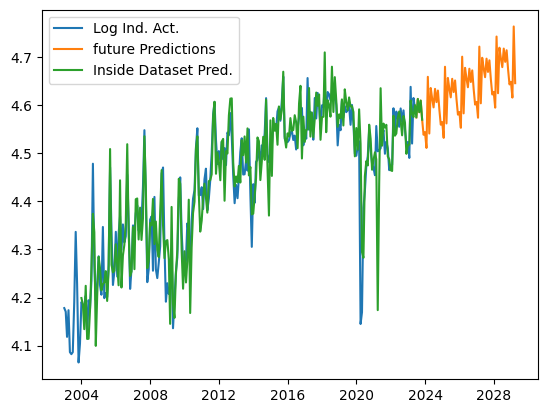

In [15]:
plt.plot(IAQ['lIndAct'], label='Log Ind. Act.')
plt.plot(model.forecast(70),label='future Predictions')
plt.plot(model.predict(start = 12, end = 250), label = 'Inside Dataset Pred.')
plt.legend()

The future predictions show a cyclical and steady growth for the industrial Activity.

In [16]:
# Further Refinement
y = IAQ['lIndAct']
Aorder = (1, 0, 0)
SAorder = (0, 1, 1, 12)
model2 = SARIMAX(y, order=Aorder, seasonal_order=SAorder, trend='c', dates=y.index)
model2=model2.fit()
model2.summary()

d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              lIndAct   No. Observations:                  246
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 359.050
Date:                              Fri, 17 Nov 2023   AIC                           -710.101
Time:                                      23:47:43   BIC                           -696.279
Sample:                                  01-01-2003   HQIC                          -704.528
                                       - 06-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0043      0.002      2.627      0.009       0.001       0.007
ar.L1          0.7771      0.031     25.337      0.000       0.717       0.837
ma.S.L12      -0.5819      0.044    -13.254      0.000      -0.668      -0.496
sigma2         0.0027      0.000     23.170      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):              1022.88
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -1.31
Prob(H) (two-sided):                  0.43   Kurtosis:                        12.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The autoregressive term is positive and is statistically significant as it´s p-value is below 0.05. <br>The seasonal moving average term is negative and is also statistically significant as it´s p-value is below 0.05. <br>


This means that annual percent growth of the industrial activity in Queretaro is positively and statistically related to the annual percent growth of the industrial activity of 12 months ago.<br>
77.7% of the annual growth of last month is passed to this month’s annual % growth, and a decrease of 58.1% in the annual growth is related to the growth in the previous month. phi0 being positive and statistically significant means that the annual growth tends to grow over time<br>

The equation would be:<br>
s12.lnIAQ = 0.0043 + 0.7771∗ar.L1.s12.lnIAQ - 0.5819∗ma.S.L12.lnIAQ + error

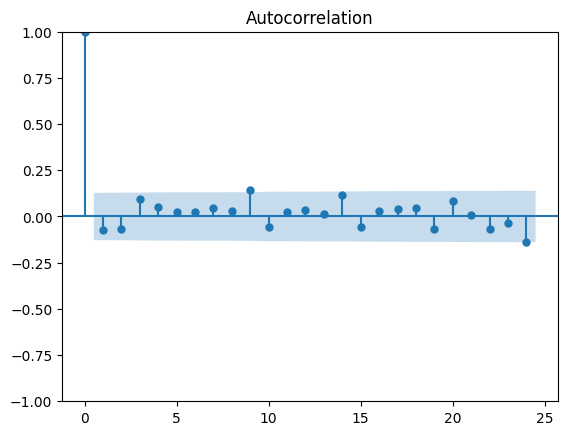

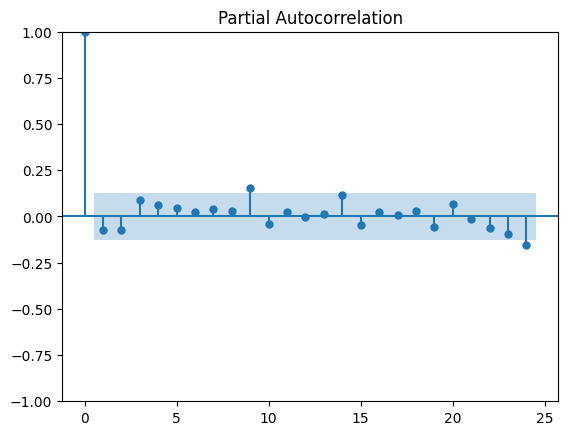

In [17]:
plot_acf(model2.resid[12:])
plot_pacf(model2.resid[12:])
plt.show()

The PACF and ACF plots show that there are various points that are meagerly signigicant so it is not really necessary to continue adding AR or MA terms.

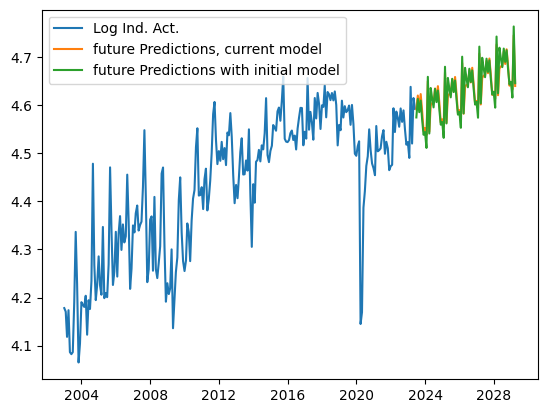

In [25]:
plt.plot(IAQ['lIndAct'], label='Log Ind. Act.')
plt.plot(model2.forecast(70),label='future Predictions, current model')
#plt.plot(model2.predict(start = 12, end = 250), label = 'Inside Dataset Pred.')
plt.plot(model.forecast(70),label='future Predictions with initial model')
plt.legend()

As we can see in the plot both models show similar results. The previous model shows forecasts with higher peaks and lower valleys than the fine tunned model but as we saw earlier it is not necessarily better.

---
# MODEL WITH THE PANDEMIC AS A VARIABLE

In [19]:
#IAQ = IAQ.copy()
dateAfter = datetime.strptime('2020-03-23', "%Y-%m-%d")
dateAfter = dateAfter.date()

dateBefore = datetime.strptime('2021-06-09', "%Y-%m-%d")
dateBefore = dateBefore.date()
IAQ['pandemic'] = 0
IAQ = IAQ.reset_index()
IAQ['d'] = IAQ['Periodos'].dt.date
#DFC= DFC[(DFC['d'] > dateAfter) & (DFC['d'] > dateBefore)]
IAQ.loc[(IAQ['d'] > dateAfter) | (IAQ['d'] > dateBefore), 'pandemic'] = 1
IAQ=IAQ.drop(columns=['d'])
IAQ=IAQ.set_index(['Periodos'])
IAQ

,IAQueretaro,lIndAct,diff12,pandemic
Periodos,,,,
2003-01-01,65.234491,4.177988,NaN,0
2003-02-01,64.750420,4.170540,NaN,0
2003-03-01,61.444991,4.118142,NaN,0
2003-04-01,64.953065,4.173665,NaN,0
2003-05-01,59.522348,4.086352,NaN,0
...,...,...,...,...
2023-02-01,89.168194,4.490524,0.014323,1
2023-03-01,103.384331,4.638453,0.044631,1
2023-04-01,91.876916,4.520450,-0.023967,1


In [20]:
Aorder = (1, 0, 0)
SAorder = (0, 1, 1, 12)
model3 = SARIMAX(y, exog=IAQ['pandemic'].copy(), order=Aorder, seasonal_order=SAorder, trend='c', dates=y.index)
model3=model3.fit()
model3.summary()

d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              lIndAct   No. Observations:                  246
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 382.580
Date:                              Fri, 17 Nov 2023   AIC                           -755.161
Time:                                      23:47:44   BIC                           -737.884
Sample:                                  01-01-2003   HQIC                          -748.195
                                       - 06-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0071      0.002      4.048      0.000       0.004       0.011
pandemic      -0.2582      0.020    -12.993      0.000      -0.297      -0.219
ar.L1          0.7777      0.038     20.463      0.000       0.703       0.852
ma.S.L12      -0.5598      0.059     -9.544      0.000      -0.675      -0.445
sigma2         0.0022      0.000     12.083      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   5.22   Jarque-Bera (JB):                 7.39
Prob(Q):                              0.02   Prob(JB):                         0.02
Heteroskedasticity (H):               0.69   Skew:                             0.13
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The *autoregressive term* is positive and is statistically significant as it´s p-value is below 0.05. <br>The *seasonal moving average term* is negative and is also statistically significant as it´s p-value is below 0.05. <br>
The *pandemic* coefficient is negative and is statistically significant as it´s p-value is below 0.05. <br>


This means that annual percent growth of the industrial activity in Queretaro is positively and statistically related to the annual percent growth of the industrial activity of 12 months ago.<br>
77.7% of the annual growth of last month is passed to this month’s annual % growth, a decrease of 55.9% in the annual growth is related to the growth in the previous month and a decrease of 25.8% in the annual growth is related to the status of the pandemic. phi0 being positive and statistically significant means that the annual growth tends to grow over time<br>

The equation would be:<br>
s12.lnIAQ = 0.0071 - 0.2582*pandemic + 0.7777∗ar.L1.s12.lnIAQ - 0.5598∗ma.S.L12.lnIAQ + error

In [21]:
df2 = [0] * 70
df2 = pd.DataFrame(df2)
df2.columns = ['pandemic']
df2

,pandemic
0,0
1,0
2,0
3,0
4,0
...,...
65,0
66,0
67,0
68,0


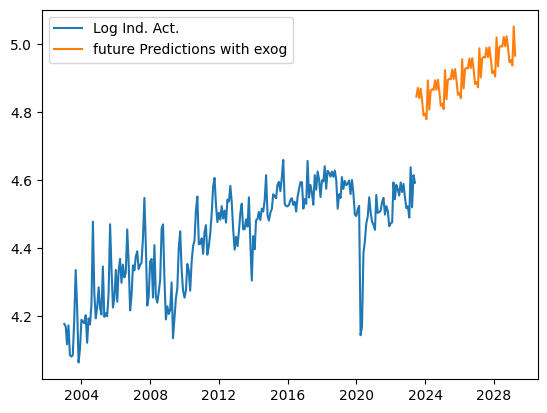

In [22]:
plt.plot(IAQ['lIndAct'], label='Log Ind. Act.')
#forecast2 = model3.forecast(70)
forecast3 = model3.forecast(70, exog=df2)
#plt.plot(model3.forecast(70, exog=df2),label='future Predictions with exog')
#plt.plot(forecast2,label='future Predictions with exog')
plt.plot(forecast3,label='future Predictions with exog')
plt.legend()

The graph shows that the model that takes into account the pandemic is more positive with it´s forecasts.

---
# CONCLUSIONS

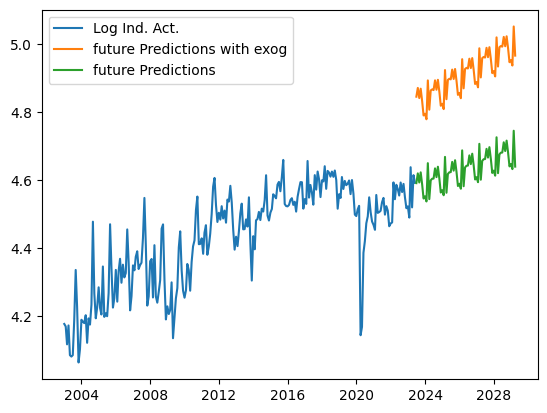

In [23]:
plt.plot(IAQ['lIndAct'], label='Log Ind. Act.')
plt.plot(model3.forecast(70, exog=df2),label='future Predictions with exog')
plt.plot(model2.forecast(70),label='future Predictions')
plt.legend()

Now starting the prediction of the data in the TS we can see that the model produces similar results to the ones in the TS, as for predictions up to 2030, we can see an average annual growth that while it oscilates it continues to grow. The main difference between a model that takes into account the status of the pandemic and one that doesn't is that the one that that **takes into account the pandemic** has a more optimistic predictions of the annual growth of the Industrial Activity in Queretaro.